In [1]:
# imports
import torch
from pytorch3d.transforms.so3 import (
    so3_exp_map,
    so3_relative_angle,
)
from pytorch3d.renderer.cameras import (
    SfMPerspectiveCameras,
)

# add path for demo utils
import sys
import os
sys.path.append(os.path.abspath(''))

""" Bad seeds and configs:
3240450701516776122, SGD lr=0.5, iters=2000
"""

# set for reproducibility
torch.manual_seed(3240450701516776122)
print(f'current torch seed: {torch.initial_seed()}')
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
    print("WARNING: CPU only, this will be slow!")

from utils import plot_camera_scene

current torch seed: 3240450701516776122


## 1. Set up Cameras and load ground truth positions

In [2]:
# load the SE3 graph of relative/absolute camera positions
camera_graph_file = './data/camera_graph.pth'
ground_truth, relative_poses, relative_edges = torch.load(camera_graph_file)
R_absolute_gt, T_absolute_gt = ground_truth
R_relative, T_relative = relative_poses

#T_absolute_gt = T_absolute_gt.reshape(-1, 1, 3)
#T_relative = T_relative.reshape(-1, 1, 3)

# the number of absolute camera positions
N = R_absolute_gt.shape[0]

# create the absolute ground truth cameras
cameras_absolute_gt = SfMPerspectiveCameras(
    R = R_absolute_gt.to(device),
    T = T_absolute_gt.to(device),
    device = device,
)

## 2. Define optimization functions

### Relative cameras and camera distance
We now define two functions crucial for the optimization.

**`calc_camera_distance`** compares a pair of cameras. This function is important as it defines the loss that we are minimizing. The method utilizes the `so3_relative_angle` function from the SO3 API.

**`get_relative_camera`** computes the parameters of a relative camera that maps between a pair of absolute cameras. Here we utilize the `compose` and `inverse` class methods from the PyTorch3D Transforms API.

In [3]:
def calc_camera_distance(R1, T1, R2, T2):
    #assert len(R1.shape) == 3
    #assert len(T1.shape) == 2
    #assert len(R2.shape) == 3
    #assert len(T2.shape) == 2
    """
    Calculates the divergence of a batch of pairs of cameras 1 and 2.
    The distance is composed of the cosine of the relative angle between
    the rotation components of the camera extrinsics and the l2 distance
    between the translation vectors.
    """
    R_distance = (1.0 - so3_relative_angle(R1, R2, cos_angle=True)).mean()
    T_distance = ((T1 - T2)**2).sum(1).mean()
    return R_distance + T_distance

def get_relative_camera(R, T, edges):
    """
    For each pair of indices (i,j) in "edges" generate a camera
    that maps from the coordinates of the camera cams[i] to
    the coordinates of the camera cams[j]
    """

    #print(f'T.shape: {T.shape}')

    (Ri,Ti), (Rj,Tj) = [
        (R[edges[:,k]], T[edges[:,k]])
        for k in (0,1)
    ]

    K = edges.shape[0]
    col = torch.tensor([0, 0, 0, 1]).view(1, 4, 1).repeat(K, 1, 1)
    #print(f'edges.shape: {edges.shape}')
    #print(f'col.shape: {col.shape}')
    #print(f'Ri.shape: {Ri.shape}')
    #print(f'Ti.shape: {Ti.shape}')

    trans_i = torch.cat((Ri, Ti.view(K, 1, 3)), dim=1)
    #print(f'trans_i_1.shape: {trans_i.shape}')
    trans_i = torch.cat((trans_i, col), dim=2)
    #print(f'trans_i_2.shape: {trans_i.shape}')

    trans_j = torch.cat((Rj, Tj.view(K, 1, 3)), dim=1)
    trans_j = torch.cat((trans_j, col), dim=2)

    trans_rel = trans_i.inverse() @ trans_j

    R_rel = trans_rel[:, :3, :3]
    T_rel = trans_rel[:, 3, :3]

    return R_rel, T_rel


## 3. Optimization
Finally, we start the optimization of the absolute cameras.

We use SGD with momentum and optimize over `log_R_absolute` and `T_absolute`. 

As mentioned earlier, `log_R_absolute` is the axis angle representation of the rotation part of our absolute cameras. We can obtain the 3x3 rotation matrix `R_absolute` that corresponds to `log_R_absolute` with:

`R_absolute = so3_exp_map(log_R_absolute)`


iteration=  0; camera_distance=2.68091e+01


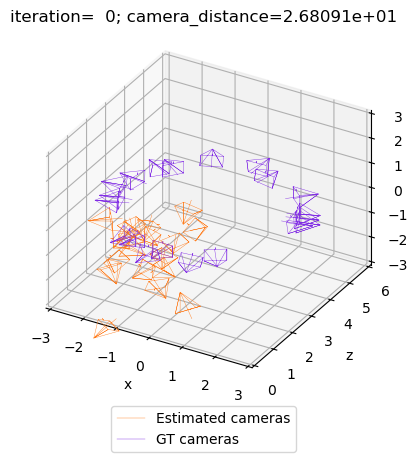

iteration=200; camera_distance=6.89029e-02


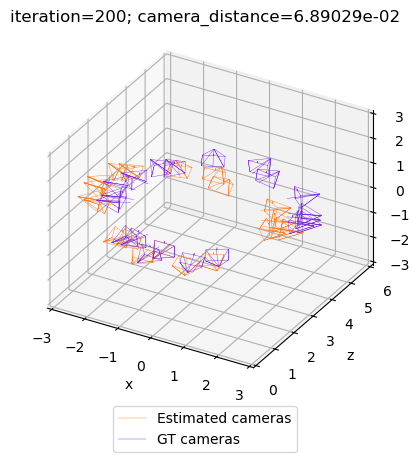

iteration=400; camera_distance=1.64930e-02


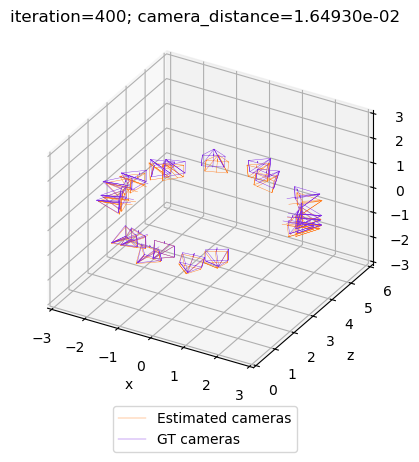

iteration=600; camera_distance=9.65810e-02


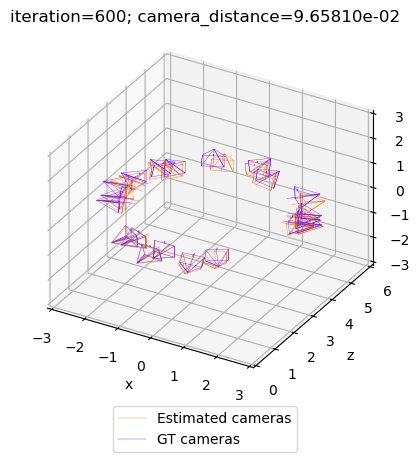

iteration=800; camera_distance=2.11350e-02


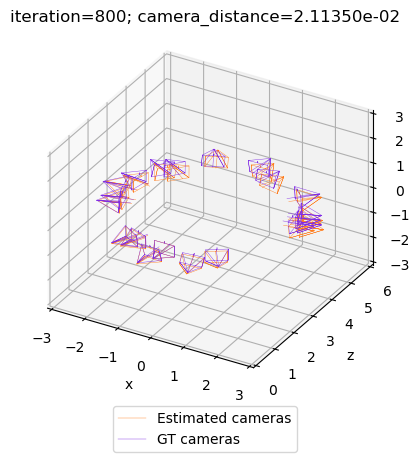

iteration=1000; camera_distance=5.56679e-02


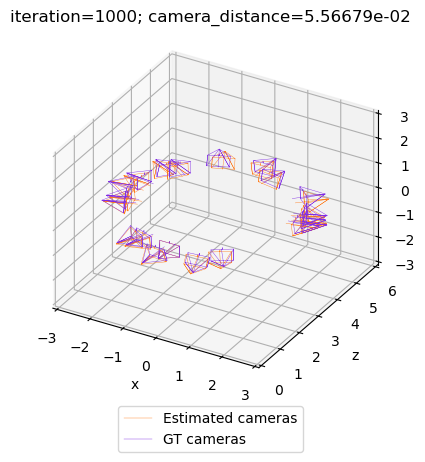

iteration=1200; camera_distance=8.99915e-03


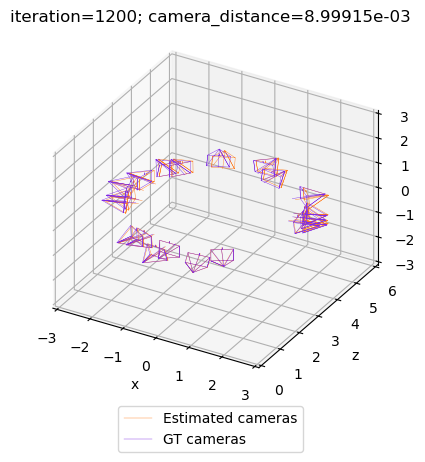

iteration=1400; camera_distance=1.08142e-02


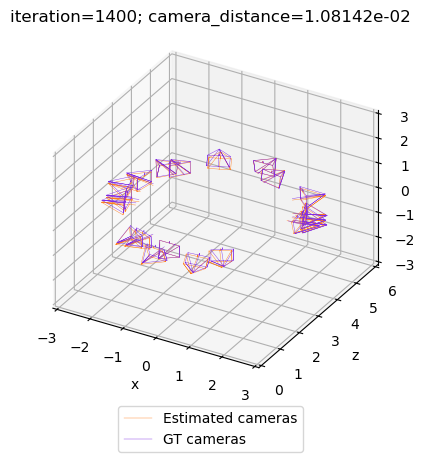

iteration=1600; camera_distance=3.48276e-02


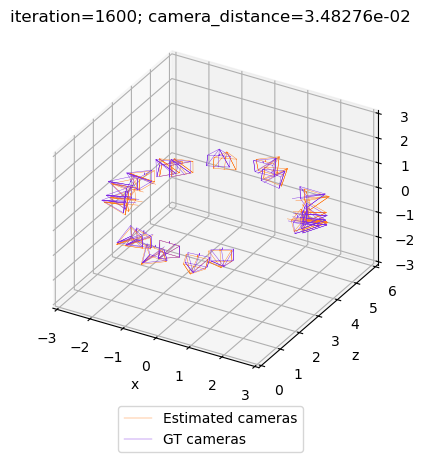

iteration=1800; camera_distance=2.46831e-02


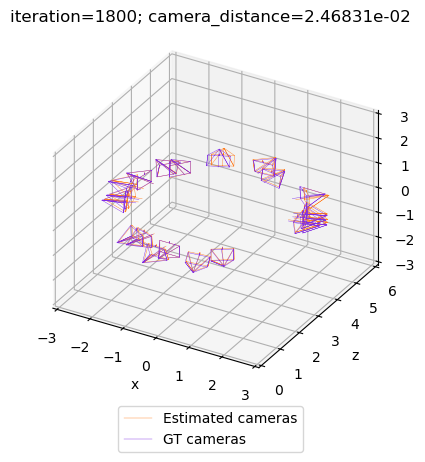

iteration=1999; camera_distance=1.28936e-02


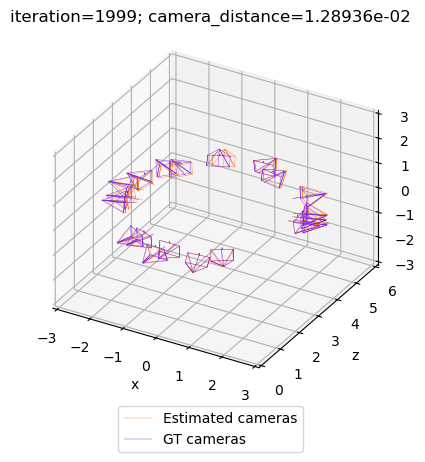

Optimization finished.


In [4]:
# initialize the absolute log-rotations/translations with random entries
log_R_absolute_init = torch.randn(N, 3, dtype=torch.float32, device=device)
T_absolute_init = torch.randn(N, 3, dtype=torch.float32, device=device)

# furthermore, we know that the first camera is a trivial one
#    (see the description above)
log_R_absolute_init[0, :] = 0.
T_absolute_init[0, :] = 0.

# instantiate a copy of the initialization of log_R / T
log_R_absolute = log_R_absolute_init.clone().detach()
log_R_absolute.requires_grad = True
T_absolute = T_absolute_init.clone().detach()
T_absolute.requires_grad = True

# the mask the specifies which cameras are going to be optimized
#     (since we know the first camera is already correct,
#      we only optimize over the 2nd-to-last cameras)
camera_mask = torch.ones(N, 1, dtype=torch.float32, device=device)
camera_mask[0] = 0.0

# init the optimizer
#optimizer = torch.optim.SGD([log_R_absolute, T_absolute], lr=.5, momentum=0.9)
optimizer = torch.optim.Adam([log_R_absolute, T_absolute], lr=.6)

# run the optimization
n_iter = 2000 # fix the number of iterations
for it in range(n_iter):
    # re-init the optimizer gradients
    optimizer.zero_grad()

    # compute the absolute camera rotations as
    # an exponential map of the logarithms (=axis-angles)
    # of the absolute rotations
    R_absolute = so3_exp_map(log_R_absolute * camera_mask)

    cameras_relative_composed = get_relative_camera(
        R_absolute, T_absolute * camera_mask, relative_edges)

    # compare the composed cameras with the ground truth relative cameras
    # camera_distance corresponds to $d$ from the description
    camera_distance = calc_camera_distance(
        *cameras_relative_composed, R_relative, T_relative)

    # our loss function is the camera_distance
    camera_distance.backward()

    # apply the gradients
    optimizer.step()

    # plot and print status message
    if it % 200==0 or it==n_iter-1:
        status = 'iteration=%3d; camera_distance=%1.5e' % (it, camera_distance)
        print(status)

        cameras_absolute = SfMPerspectiveCameras(
            R = R_absolute,
            T = T_absolute * camera_mask,
            device = device,
        )
        plot_camera_scene(cameras_absolute, cameras_absolute_gt, status)

print('Optimization finished.')
